### 배운 점

- 모델링(LinearDiscriminantAnalysis)
- Tukey method를 이용한 이상치 탐색

### Titanic Top 4% with ensemble modeling

#### ------------------------------ 목차 ------------------------------

- **1. 소개**
- **2. 데이터 load 및 확인**
    - 2.1 Load data
    - 2.2 이상치 탐지
    - 2.3 train, test set 결합
    - 2.4 null 값, 결측치 값 확인
- **3. Feature 분석**
    - 수치형 변수
    - 범주형 변수
- **4. 결측치 채우기**
    - 4.1 Age
- **5. Feature Engineering**
    - 5.1 Name / Title
    - 5.2 Family Size
    - 5.3 Cabin
    - 5.4 Ticket
- **6. Modeling**
    - 6.1 간단한 모델링
        - 6.1.1 교차 검증한 모델
        - 6.1.2 하이퍼 파라미터 튜닝
        - 6.1.3 학습 곡선 표시(Plot learning curves)
        - 6.1.4 트리 기반 분류기의 feature 중요도
    - 6.2 앙상블 모델링
        - 6.2.1 모델 결합
    - 6.3 예측
        - 6.3.1 예측 및 결과 제출

### 1. 소개

타이타닉 데이터 셋은 Feature Enginering과 앙상블 모델링을 소개하기 좋은 데이터라고 생각이 되어 이 대회를 선택하게 되었다. 먼저 특성 분석을 몇가지 한 뒤 feature engineering을 하고 마지막으로 voting을 통해 생존 예측하는 모델링을 만들 것이다.

이 노트는 세 가지 주요 part를 따를 것이다.

- **Feature 분석**
- **Feature engineering**
- **모델링**

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

### 2. 데이터 load 및 확인

#### 2.1 Load data

In [2]:
# Load data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
IDtest = test["PassengerId"]

#### 2.2 이상치 탐지

In [25]:
def detect_outliers(df, n, features):
    """
    Dataframe인 df를 가지고 
    n보다 많은 이상치를 포함하는 인덱스 return
    """
    outlier_indices = []
    
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
#         print(col, Q1, Q3)
        IQR = Q3 - Q1
        
        outlier_step = 1.5 * IQR
        
        outlier_list_col = df[(df[col] < Q1 - outlier_step) |
                              (df[col] > Q3 + outlier_step)].index
        
        outlier_indices.extend(outlier_list_col)
    
    # index oount
    outlier_indices = Counter(outlier_indices)
    
    # n보다 높은 index 저장
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
    
#     print(multiple_outliers)
    return multiple_outliers
    
    
Outliers_to_drop = detect_outliers(train,2,["SibSp","Parch","Fare"])

이상치는 회귀에서 예측에 극적인 영향을 줄 수 있다. Tukey method(IQR을 이용한 이상치 탐지)를 이용해 이상치를 확인했다. 수치 데이터인 ("SibSp","Parch","Fare")에서 이상치를 탐지하였고 인덱스별 두 행에서 이상치가 있을 경우 제거하기로 했다.

In [26]:
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


10개의 이상치를 볼 수 있다. 28,29,342 승객은 Ticket 요금이 높고 다른 7명은 SibSP의 값이 높은 것을 볼 수 있다.

In [31]:
# Drop outliers
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

#### 2.3 train, test set 결합

In [32]:
train_len = len(train)
dataset = pd.concat(objs=[train,test], axis = 0).reset_index(drop=True)

#### 2.4 null 값, 결측치 값 확인

In [36]:
# Fill empty and NaNs values with NaN
dataset = dataset.fillna(np.nan)

# Null값 수 확인
dataset.isnull().sum()

Age             256
Cabin          1007
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

**`Age`, `Cabin`** feature은 결측값 채우는 것이 중요하다.

In [40]:
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
PassengerId    881 non-null int64
Survived       881 non-null int64
Pclass         881 non-null int64
Name           881 non-null object
Sex            881 non-null object
Age            711 non-null float64
SibSp          881 non-null int64
Parch          881 non-null int64
Ticket         881 non-null object
Fare           881 non-null float64
Cabin          201 non-null object
Embarked       879 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [41]:
train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [42]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [43]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


### 3. Feature 분석

#### 3.1 수치형 변수

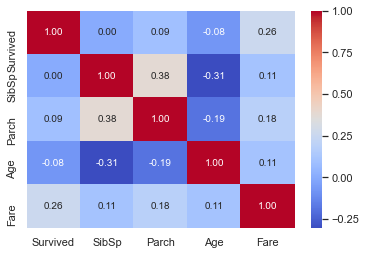

In [55]:
g = sns.heatmap(train[["Survived","SibSp","Parch","Age","Fare"]].corr(), 
                annot=True, # 값 표시
                fmt = ".2f", # format
                cmap = "coolwarm")

Fare feature만 Survived와 유의한 상관관계가 있음을 확인할 수 있다.

다른 feature가 유용하지 않다는 의미는 아니다. 이러한 feature의 하위 항목은 생존과 상관이 있을 수 있다. 이를 확인하려면 각 feature를 자세히 살펴봐야 한다.

[참고](https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling)